In [6]:
from env import API_KEY
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt

from datetime import datetime
import os
from alpha_vantage.timeseries import TimeSeries
import warnings
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
#I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

In [7]:
def format_data(data):
    for key in data:
        for col in data[key]:
            data[key][col] = float(data[key][col])
    return data

In [8]:
def adjust(date, close, adj_close, in_col, rounding=4):
    '''
    If using forex or Crypto - Change the rounding accordingly!
    '''
    try:
        factor = adj_close / close
        return round(in_col * factor, rounding)
    except ZeroDivisionError:
        print('WARNING: DIRTY DATA >> {} Close: {} | Adj Close {} | in_col: {}'.format(date, close, adj_close, in_col))
        return 0

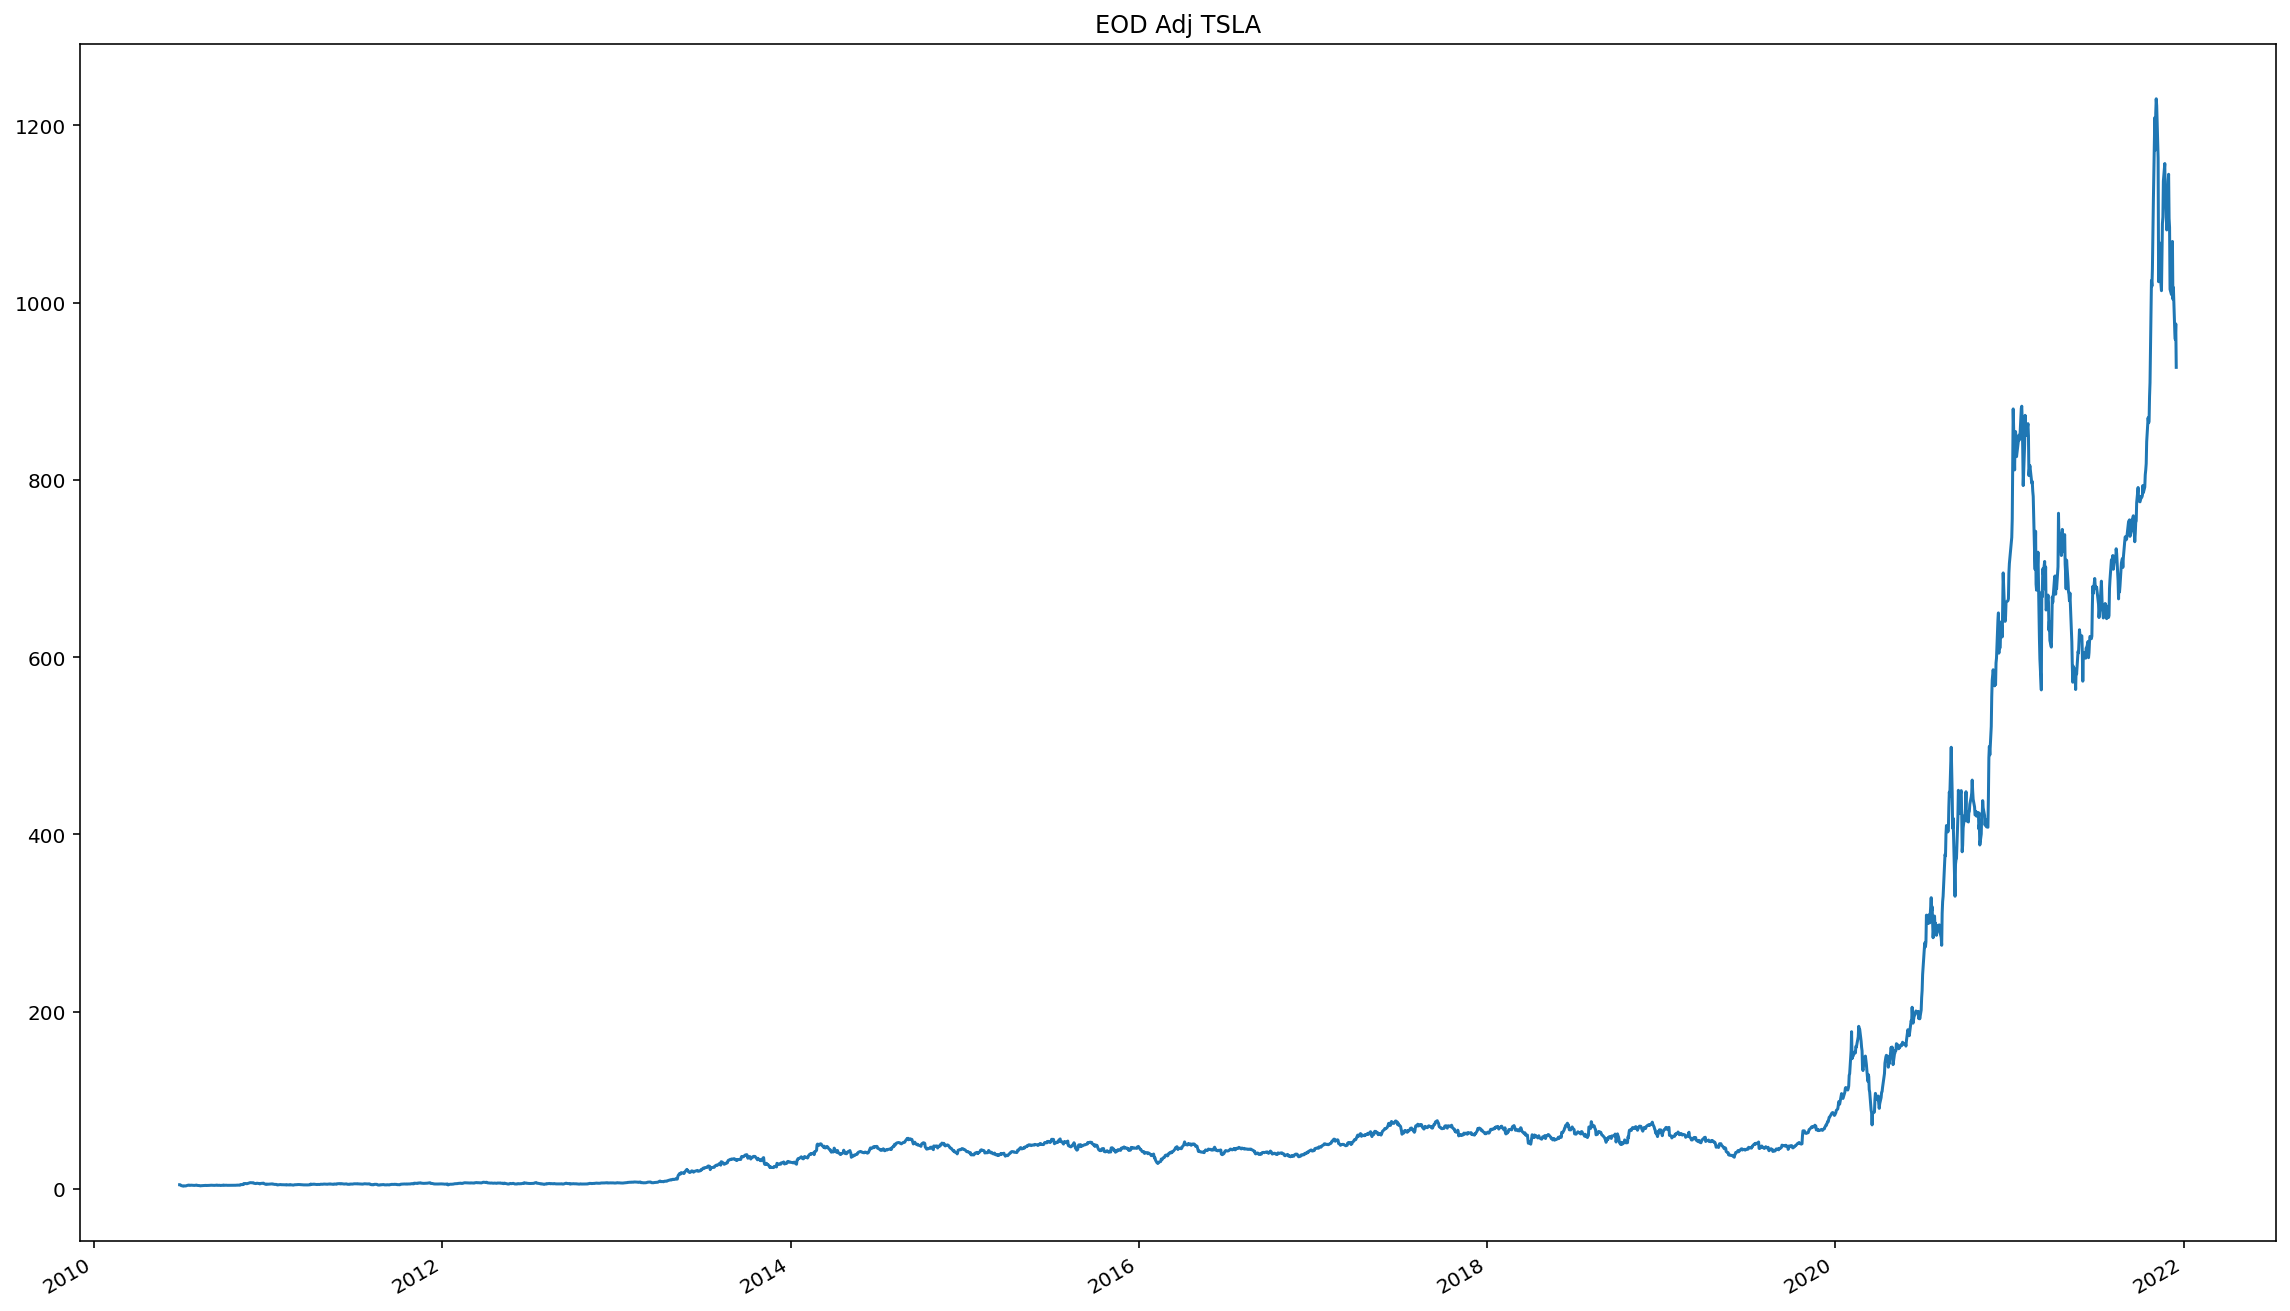

In [9]:
ts = TimeSeries(key=API_KEY)
symbol = 'TSLA'
# Get json object with the intraday data and another with  the call's metadata
data, meta_data = ts.get_daily_adjusted(symbol,outputsize='full')
data_df = (
    pd.DataFrame(format_data(data)).T
    .rename(axis='index',mapper=lambda x: pd.to_datetime(x))
    )
data_df['5. adjusted close'].plot()
plt.tight_layout()
plt.title(f'EOD Adj {symbol}')
plt.show()


In [10]:
# Let's just look at 2015 onwards
data_df.sort_index(inplace=True)
data_df = data_df.loc['2018-01-01':]
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close','5. adjusted close']]
data_df.columns = ['High', 'Low', 'Open', 'Close','Adj']

In [11]:
adj_factor = data_df['Adj']/data_df['Close']
data_df = data_df[data_df.columns[:4]].mul(adj_factor,axis=0)

In [12]:
class boll_bander(bt.Strategy):
    # Set a bollinger band indicator, buy when the price exceeds the lower band, sell when price exceeds higher band.
    # Set the parameters for the bollinger band. I chose a 21 day period as that mimics the number of days in a trading month, a smaller standard deviation on the band
    # gives more entry & exit opportunities
    params = dict(
            bperiod=21
            ,dev=0.5)
    
    def __init__(self):

        #Define Bollinger band

        self.boll = bt.ind.BollingerBands(period=self.p.bperiod, devfactor=self.p.dev, plot=True, plotname='Bollinger Band', subplot=False)

        #Define cross-over points

        self.buysig = bt.indicators.CrossOver(self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
        self.sellsig = bt.indicators.CrossOver(self.data0, self.boll.lines.top,plotname='sell signal', plot=True)
    def next(self):

        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=1)   # enter long

        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position

In [13]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(boll_bander)
results = cerebro.run()

[[<Figure size 1152x648 with 6 Axes>]]

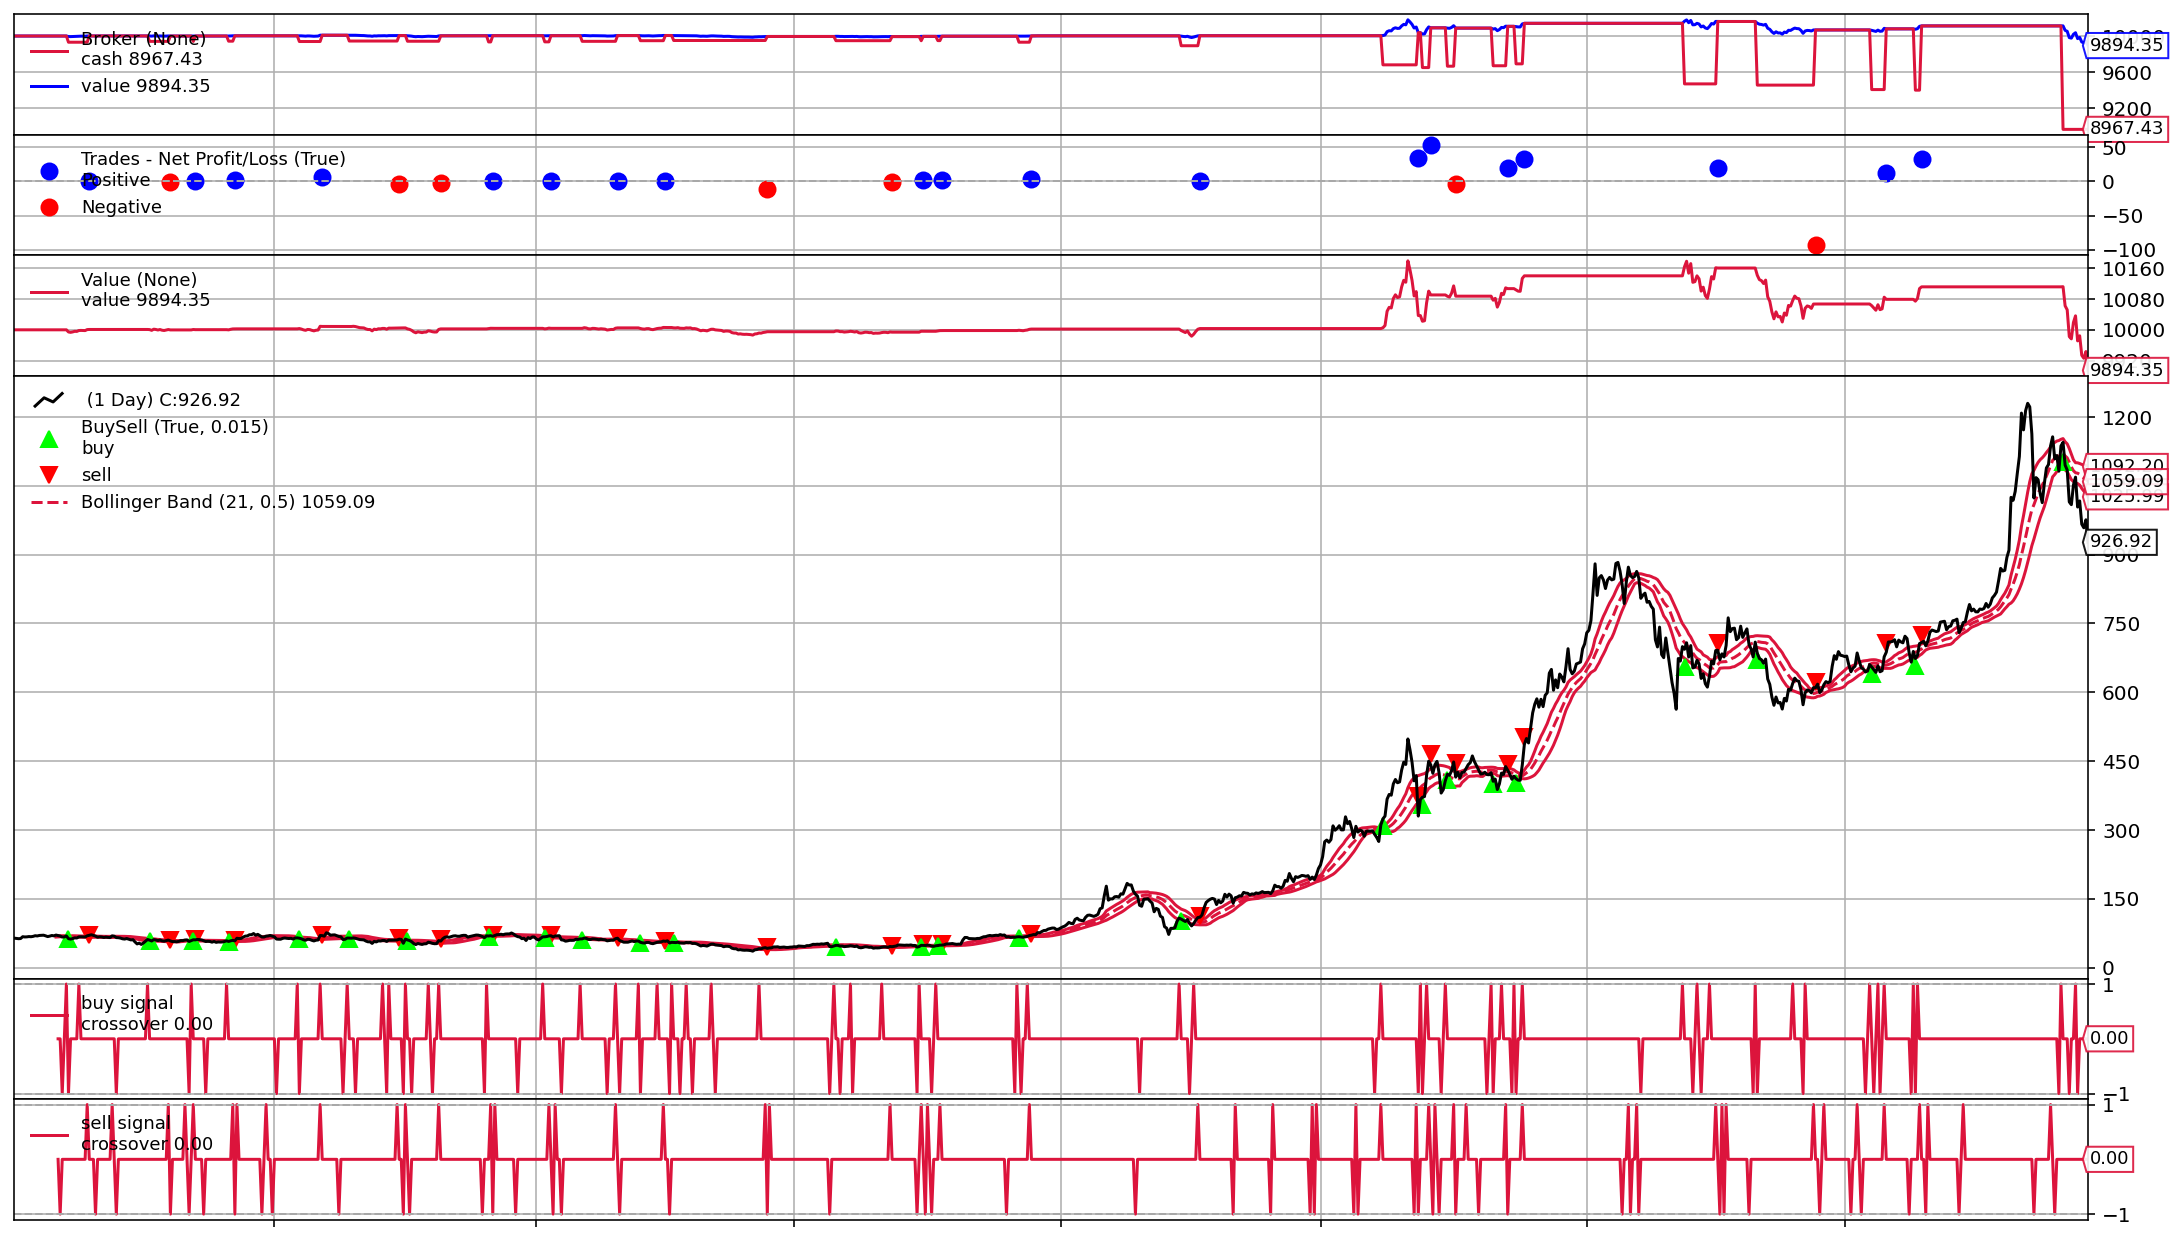

In [14]:
cerebro.plot(tight=False,numfigs=1,iplot=False, volume=False, width=60)

In [15]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']}")
print(f'Norm. Annual Return: {results[0].analyzers.returns.get_analysis()["rnorm100"]}')
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']}")


Sharpe: -0.18612500308311689
Norm. Annual Return: -0.2678416392437288
Max Drawdown: 2.8004744475567906
